In [ ]:
# import Pkg; Pkg.add("GraphPlot")
# import Pkg; Pkg.add("Compose")
# import Pkg; Pkg.add("Cairo")
# import Pkg; Pkg.add("Fontconfig")
# import Pkg; Pkg.add("Colors")
# import Pkg; Pkg.add("Graphs")
# import Pkg; Pkg.add("CausalInference")

# Causal discovery using Julia: A brief introduction, a simulation, and a possible use case

In situations where the causal structure a dataset is unknown, algorithms can be used to estimate DAGs for use in causual inference.

In [this blog post](https://medium.com/juliazoid/simulating-causal-effects-with-julia-47abca8ab73), I introduced the concept of a DAG (directed acyclic graph), and why a DAG is necessary for causal inference. While DAGs are a powerful tool for inferring causal effects, if an incorrect DAG is used to conduct an analysis, the resulting parameter estimates will be biased. In cases when researchers are uncertain about the causal structure of the data, but still want to conduct causal inference, causal discovery algorithms can be a useful as a first step to determining causal relationships

### Causal diagram used in this article

In this article, we will simulate spending patterns at a store. We will have covariates for age, a person's distance from the store, a person's personal income, the population density of the person's neighborhood, and the zoning restrictions in place around the person's neighborhood. 

In [1]:
using Pkg
Pkg.add("CausalInference")

    Updating registry at `C:\Users\Alexander\.julia\registries\General.toml`
   Resolving package versions...
   Installed MicroCollections ─ v0.2.0
   Installed Referenceables ─── v0.1.3
   Installed LRUCache ───────── v1.6.1
   Installed InitialValues ──── v0.3.1
   Installed ThreadsX ───────── v0.1.12
   Installed Accessors ──────── v0.1.36
   Installed Memoization ────── v0.2.1
   Installed DefineSingletons ─ v0.1.2
   Installed TabularDisplay ─── v1.2.0
   Installed Baselet ────────── v0.1.1
   Installed CompositionsBase ─ v0.1.2
   Installed ArgCheck ───────── v2.3.0
   Installed BangBang ───────── v0.4.1
   Installed Transducers ────── v0.4.81
   Installed SplittablesBase ── v0.1.15
   Installed PrecompileTools ── v1.2.1
   Installed CausalInference ── v0.11.5
    Updating `C:\Users\Alexander\.julia\environments\v1.7\Project.toml`
  [8e462317] + CausalInference v0.11.5
    Updating `C:\Users\Alexander\.julia\environments\v1.7\Manifest.toml`
  [7d9f7c33] + Accessors v0.1.36
  [dc

   Resolving package versions...
   Installed Graphs ─ v1.9.0
    Updating `C:\Users\Alexander\.julia\environments\v1.7\Project.toml`
  [86223c79] + Graphs v1.9.0
    Updating `C:\Users\Alexander\.julia\environments\v1.7\Manifest.toml`
  [86223c79] ↑ Graphs v1.8.0 ⇒ v1.9.0
Precompiling project...
  ✓ Graphs
  ✓ SimpleWeightedGraphs
  ✓ MetaGraphs
  ✓ GraphRecipes
  ✓ ImageSegmentation
  ✓ Images
  ✓ CausalInference
  7 dependencies successfully precompiled in 20 seconds (335 already precompiled)


In [14]:
import Pkg; Pkg.add("GraphPlot")
import Pkg; Pkg.add("Compose")
import Pkg; Pkg.add("Cairo")
import Pkg; Pkg.add("Fontconfig")
import Pkg; Pkg.add("Colors")
import Pkg; Pkg.add("Graphs")
import Pkg; Pkg.add("CausalInference")

   Resolving package versions...
    Updating `C:\Users\Alexander\.julia\environments\v1.7\Project.toml`
  [5ae59095] + Colors v0.12.10
  No Changes to `C:\Users\Alexander\.julia\environments\v1.7\Manifest.toml`


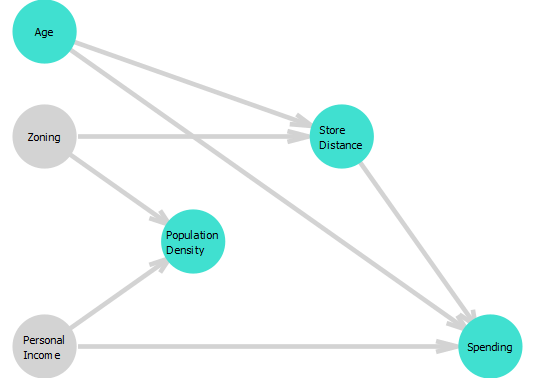

In [1]:
using Graphs, GraphPlot
using Compose, Cairo, Fontconfig
using Colors

g = SimpleDiGraph(6)
add_edge!(g, 3,1)
add_edge!(g, 4,1)
add_edge!(g, 4,5)
add_edge!(g, 6,3)
add_edge!(g, 6,5)
add_edge!(g, 2,1)
add_edge!(g, 2,3)




nodelabel = ["Spending", "Age",  "Store\nDistance",
    "Personal\nIncome", "Population\nDensity", "Zoning"

]
x_dims = Dict("Spending" =>4, 
    "Age"=>1, 
    "Store\nDistance"=>3, 
    "Personal\nIncome"=>1, 
    "Population\nDensity"=>2, 
    "Zoning"=>1)
locs_x = [x_dims[label] for label in nodelabel]
y_dims = Dict("Spending" =>4, 
    "Age"=>1, 
    "Gender"=>1, 
    "Store\nDistance"=>2, 
    "Personal\nIncome"=>4, 
    "Population\nDensity"=>3, 
    "Zoning"=>2)
locs_y = [y_dims[label] for label in nodelabel]



nodefillc_dict = 
Dict("Spending" =>colorant"turquoise", 
    "Age"=>colorant"turquoise", 
    "Gender"=>colorant"turquoise", 
    "Store\nDistance"=>colorant"turquoise", 
    "Personal\nIncome"=>colorant"lightgrey", 
    "Population\nDensity"=>colorant"turquoise", 
    "Zoning"=>colorant"lightgrey")

nodefillc = [nodefillc_dict[label] for label in nodelabel]

nodestrokelw = [0, 0, 0, 0, 0, 0]


g_plot = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15, NODELABELSIZE = 3, nodefillc=nodefillc)
draw(PNG("causal_discovery_1.png", 16cm, 16cm),g_plot)
g_plot

As shown in the DAG, we will assume that:  
1. Older people spend more than younger people
2. Older people will choose to live farther from stores than younger people (this is kind of contrived, but my wife has told me before that she wouldn't ever want to live more than an hour from a Target, so it could be true in some hypothetical world)
3. Zoning requirements may force stores to be located at a greater distance from the individual
4. Zoning requirements influence population density in the area
5. Individuals with higher personal income levels will be willing to live in areas of higher population density
6. Individuals with higher personal income levels will spend more at stores
7. There are no outside variables that are a common cause of any variables we have mentioned

We will further assume that information on age, distance from stores, spending patterns, and populationi density in an individual's zip code are available to the analysis, but that information on zoning and personal income is expensive to obtain. 

This simulation is intended to evaluate whether causal discovery may be used in a specific use case. Imagine that we are working on a marketing team, and we want to get a precise estimate of the effect of distance from the store on spending patterns. Further imagine that we want to avoid spending too much money on obtaining information regarding zoning patterns and personal income, but that that information is available at a given cost per customer. 

In this scenario, we might be able to spend a relatively small amount of money to obtain all available for a small subset of the patients, and use that data to create a causal diagram. Then, we could use that causal diagram to determine which variables in our freely available dataset we should condition on to do our analysis.

By looking at the DAG, we can see that we can block the backdoor path by conditioning by age alone. 

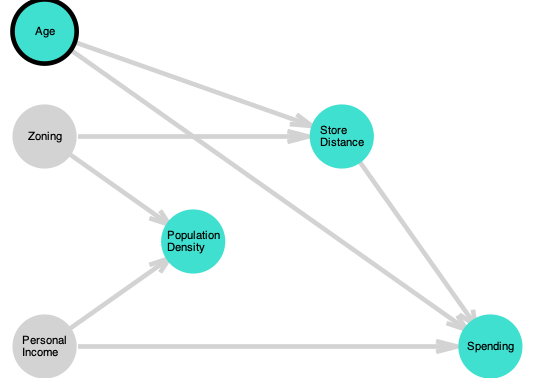

In [5]:


nodestrokelw = [0, 2, 0, 0, 0, 0]


g_plot = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15, NODELABELSIZE = 3, nodefillc=nodefillc)
draw(PNG("causal_discovery_2.png", 16cm, 16cm),g_plot)
g_plot

However, if we were to condition on population density, we would be conditioning on a collider (also known as [M bias](https://towardsdatascience.com/causal-inference-in-data-science-structure-of-m-bias-with-confounding-adjustment-70e4a263ad08)) and opening a backdoor path between store distance and spending.

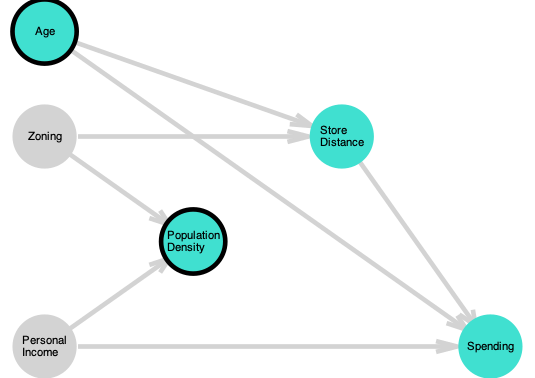

In [64]:
nodestrokelw = [0, 2, 0, 0, 2, 0]


g_plot = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15, NODELABELSIZE = 3, nodefillc=nodefillc)
draw(PNG("causal_discovery_m_bias.png", 16cm, 16cm),g_plot)
g_plot

We could of course condition on all of these variables, but it would be expensive to obtain data for all customers, and our confidence intervals would be wide because of [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity). 

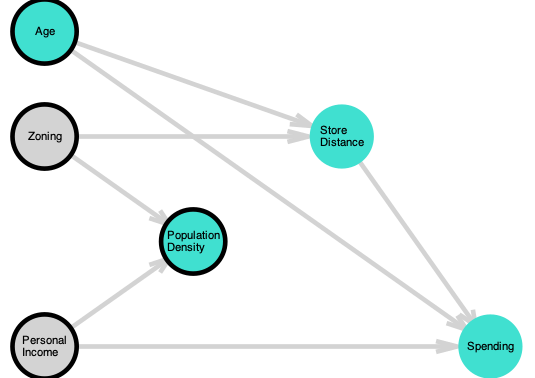

In [66]:
nodestrokelw = [0, 2, 0, 2, 2, 2]


g_plot = gplot(g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15, NODELABELSIZE = 3, nodefillc=nodefillc)
draw(PNG("causal_discovery_3.png", 16cm, 16cm),g_plot)
g_plot

First, let's define a function to simulate data from this DAG

In [17]:
using DataFrames
"""
Create a dataframe with the relationships shown in the DAG
"""
function get_data(n::Int, actual_spending_decrease::Float64 = -2.0)
    age =  rand(n) .* 50  
    zoning = rand(n) 
    personal_income = rand(n) 
    store_distance = ( rand(n) .* .1 .+ (age ./ 100) .+ zoning ) .* 100 ## pretend that people who are old live farther from stores

    
    population_density = (zoning .+ personal_income .+ rand(n) )
    spending = ((personal_income .* 100) .+ age .+ (store_distance .* actual_spending_decrease) .+ rand(n) * 100)
## Note: the order of these needs to be the same as the order of the names in the original DAG so that the causal discovery algorithm can work right
    return DataFrame(spending = spending, age = age, store_distance = store_distance,
        personal_income = personal_income, 
        population_density = population_density, 
         zoning = zoning,  )
    
end



get_data

If we conduct an unadjusted analysis, we will get a biased estimate of the effect of store distance on spending

In [67]:
using GLM 
df = get_data(5000000)
lm(@formula(spending ~ store_distance), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

spending ~ 1 + store_distance

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                    Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)     109.103    0.0510028     2139.15    <1e-99  109.003    109.203
store_distance   -1.80103  0.000590968  -3047.59    <1e-99   -1.80219   -1.79987
────────────────────────────────────────────────────────────────────────────────

As discussed above, if we condition only on age, we obtain an unbiased estimate of the effect of store distance on spending (-2.0)

In [68]:
lm(@formula(spending ~ store_distance + age), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

spending ~ 1 + store_distance + age

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)     99.9799   0.0503169     1987.01    <1e-99   99.8813   100.079
store_distance  -1.99915  0.000629403  -3176.26    <1e-99   -2.00038   -1.99792
age              0.99863  0.00141326     706.61    <1e-99    0.99586    1.0014
───────────────────────────────────────────────────────────────────────────────

And, if we were to condition on both age and population density (the "free" variables available to us) we would induce M-bias and have a biased estimate again

In [69]:
lm(@formula(spending ~ store_distance + age + population_density), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

spending ~ 1 + store_distance + age + population_density

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error         t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)         52.4224   0.0571568      917.17    <1e-99   52.3104    52.5345
store_distance      -2.49213  0.000666522  -3739.00    <1e-99   -2.49343   -2.49082
age                  1.49162  0.00128333    1162.31    <1e-99    1.48911    1.49414
population_density  49.7762   0.0386726     1287.12    <1e-99   49.7004    49.852
───────────────────────────────────────────────────────────────────────────────────

We could also adjust on all of the possible variables, but notice how the standard error values are much higher here than when we just adjusted for age alone. 

In [70]:
lm(@formula(spending ~ store_distance + age + population_density + zoning + personal_income), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

spending ~ 1 + store_distance + age + population_density + zoning + personal_income

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error        t  Pr(>|t|)   Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)          49.9691      0.0516369    967.70    <1e-99  49.8679      50.0703
store_distance       -1.994       0.00447123  -445.96    <1e-99  -2.00276     -1.98524
age                   0.993022    0.00455984   217.78    <1e-99   0.984085     1.00196
population_density    0.00501536  0.0447225      0.11    0.9107  -0.0826392    0.0926699
zoning               -0.557078    0.451542      -1.23    0.2173  -1.44208      0.327928
pers

Now that we understand what's going on, let's see if causal discovery is able to recover our DAG from the simulated data. In this post, I'll use the `CausalInference` Julia package to attempt to recover causal relationships.

### PC vs FCI algorithms

The `CausalInference` Julia package uses two algorithms for causal discovery. The PC algorithm (named after Peter Spirtes and Clark Glymour) can be used in situations where causal sufficiency can be assumed. That is, the PC algorithm should only be used when a researcher is sure that there are no common causes of any variables included. In the PC algorithms, an edge (or line between variables) can indicate that two variables may have a common cause (if an edge is bidirectional), an edge can indicate that one variable is a cause of the other variable (if an edge is unidirectional) or that there is no relationship between the two variables (shown by no edges between the two varibles).

The FCI (Fast Causal Inference) algorithm is intended for use in cases where there may be unmeasured confounders between variables. There are many types of edges in graphs produced by FCI, and the documentation for [this python package](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/FCI.html) is a good resource for understaanding what they mean. 

In both algorithms, one may set the cutoff `p` associated with the test for dependence between nodes. If `p` is very low, the resulting graph may have too few edges.

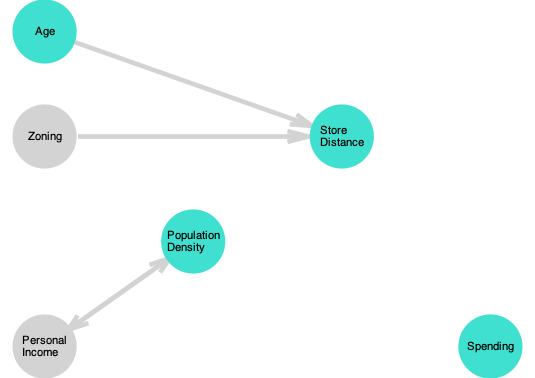

In [22]:
using CausalInference
using TikzGraphs
df = get_data(300)
est_g = pcalg(df, 0.00000000000001, gausscitest)
nodestrokelw = [0, 0, 0, 0, 0, 0]
g_plot = gplot(est_g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15, NODELABELSIZE = 3, nodefillc=nodefillc)
draw(PNG("causal_discovery_4.png", 16cm, 16cm),g_plot)
g_plot

If `p` is too high, the resulting graph will probably have too many edges:

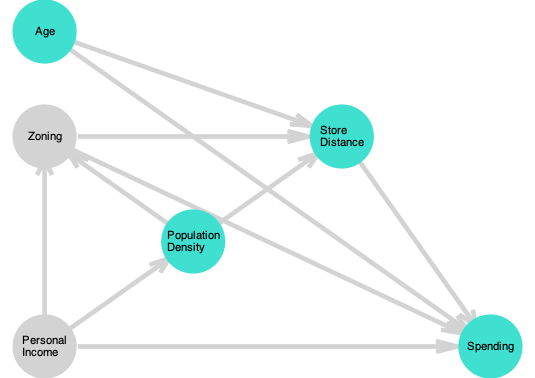

In [23]:
est_g = pcalg(df, .9, gausscitest)
nodestrokelw = [0, 0, 0, 0, 0, 0]
g_plot = gplot(est_g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15, NODELABELSIZE = 3, nodefillc=nodefillc)
draw(PNG("causal_discovery_5.png", 16cm, 16cm),g_plot)
g_plot

The [package documentation](https://mschauer.github.io/CausalInference.jl/latest/examples/pc_basic_examples/) uses a parameter value of 0.01, which we will use for the rest of the post. In practice, `p` should be selected based on the size of the data (because tests done on a larger dataset will be more powerful even at the same cutoff level) and a range of parameter values should be used for sensitivity analyses. Note that the DAG we recover using 0.01 as our parameter value is the same as our original DAG

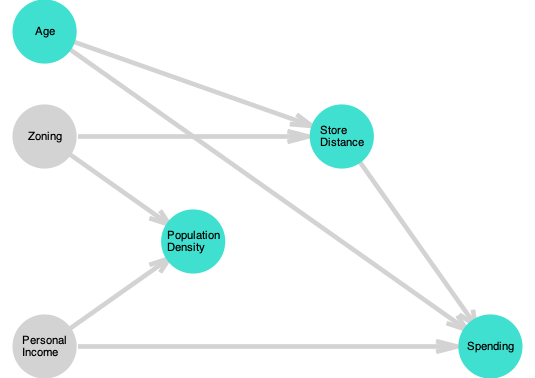

In [72]:
est_g = pcalg(df, 0.01, gausscitest)
nodestrokelw = [0, 0, 0, 0, 0, 0]
g_plot = gplot(est_g, locs_x, locs_y, nodelabel=nodelabel, 
    nodestrokec = "black", nodestrokelw = nodestrokelw, NODESIZE = .15, NODELABELSIZE = 3, nodefillc=nodefillc)
draw(PNG("causal_discovery_6.png", 16cm, 16cm),g_plot)
g_plot

Now, let's look at how the FCI algorithm handles these data. (The nodes are oriented differently because we are using a different graphing library here to accommodate the different types of edges.) Note that I increased the sample size a lot, and it still ended up with one of the arrows reversed. I believe that the FCI algorithm would do better if we used longitudinal data, and gave the algorithm more information on which causal relationships are impossible.

┌ Warning: test.pdf already exists, overwriting!
└ @ TikzPictures ~/.julia/packages/TikzPictures/4zjh8/src/TikzPictures.jl:333


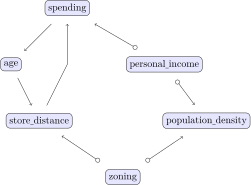

In [25]:
using TikzPictures
df = get_data(1000000)
est_g = fcialg(df, 0.1, gausscitest)
p = plot_fci_graph_tikz(est_g, [col for col in names(df)])
TikzPictures.save(TikzPictures.PDF("test"), p)
p

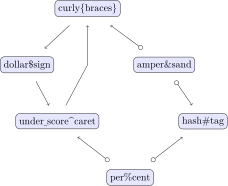

In [40]:
## for testing 
names_to_use = ["curly{braces}"
 "dollar\$sign"
 "under_score^caret"
 "amper&sand"
 "hash#tag"
 "per%cent"]
p = plot_fci_graph_tikz(est_g, names_to_use)
p

Now, we will define some functions to conduct our simulations.

In [29]:
using CausalInference

"""Create data and determine whether the causal discovery algorithm worked correctly"""
function simulate_discovery_pc(n::Int)
    df = get_data(n)
    est_g = pcalg(df, 0.01, gausscitest)
    return est_g == g
    
    
end

simulate_discovery_pc

In [46]:
using GLM, Distributions
"""Get the confidence interval of the desired parameter when controlling for all covariates"""
function get_confint_width_control_all(n::Int)
    df = get_data(n)
    mod = lm(@formula(spending ~ store_distance + age + population_density + zoning + personal_income), df)
    return stderror(mod)[2] * 2* quantile(Normal(0.0, 1.0),.975)
    
end

get_confint_width_control_all

In [47]:
"""Get the confidence interval of the desired parameter when controlling for just age"""
function get_confint_width_control_age(n::Int)
    df = get_data(n)
    mod = lm(@formula(spending ~ store_distance + age), df)
    return stderror(mod)[2] * 2* quantile(Normal(0.0, 1.0),.975)
    
end

get_confint_width_control_age

And, we'll use simulation to see how causal inference might do under many possible sample sizes. Here, we'll pretend that there are 100,000 possible customers in our store's dataset, so we get information on age and population density for "free" for all of those customers. However, we may choose to purchase additional information for a smaller number of customers.

In [48]:
sample_sizes = [200,500,1000, 2000, 3000, 5000, 8000, 10000, 100000]

9-element Vector{Int64}:
    200
    500
   1000
   2000
   3000
   5000
   8000
  10000
 100000

In [49]:
widths_control_all = [ mean([get_confint_width_control_all(sample_size) for i in 1:50]) 
    for sample_size in sample_sizes]

9-element Vector{Float64}:
 2.8115630705511534
 1.7676608862714198
 1.244541315132393
 0.8793204902309119
 0.7164897592324871
 0.5547073387754579
 0.43917852198231894
 0.39189421712184797
 0.12395185564974553

In [55]:
widths_control_age = [ mean([get_confint_width_control_age(sample_size) for i in 1:50]) 
    for sample_size in sample_sizes]

9-element Vector{Float64}:
 0.39066356290977355
 0.24687584500294046
 0.17445306399686047
 0.12343422155246556
 0.10035008540387573
 0.0782271754568998
 0.06165551987110357
 0.05514468317732508
 0.017436101603674883

In [51]:
prop_correct_dag = [ mean([simulate_discovery_pc(sample_size) for i in 1:50]) 
    for sample_size in sample_sizes]

9-element Vector{Float64}:
 0.02
 0.08
 0.26
 0.66
 0.9
 0.98
 1.0
 1.0
 0.98

In [52]:
estimate_from_age_control = mean([get_confint_width_control_age(sample_sizes[length(sample_sizes)]) 
        for i in 1:500]) ## Assume that we can get this data for free


0.017441668616459544

Finally, let's look at how the efficiency of estimation changes as we increase our sample size.  

In this hypothetical scenario, there are three possible strategies we could use to estimate the effect of store distance on spending. 
1. Sample a given amount of data (e.g. for 3,000 customers), and use all variables (both those which we have "free" and "expensive" data for to estimate the effect  
2. Sample a given amount of data, use causal discovery to identify age as the variable that needs to be controlled, and estimate the effect controlling for only age on the smaller subsample of data  
3. Sample a given amount of data, use causal discovery to identify age as the variable that needs to be controlled, and estimate the effect controlling for only age on the full population that we have "free" data for (100,000 customers)  

Note that both controlling for age and controlling for all possible variables yield unbiased estimates of our causal parameter.

In our graph, we can see that the confidence interval width for age (estimated from strategies 2 and 3) is always smaller than the interval width when controlling for all variables. However, we can only realistically use those strategies if we have enough data to correctly identify the causal structure of the data. So, strategy 2 and 3 are always better than strategy 1 as long as we have at least 5,000 patients.  





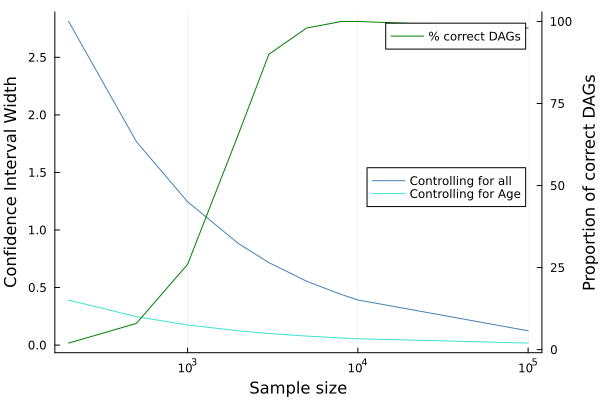

In [62]:
using StatsPlots
p = StatsPlots.plot(xlabel = "Sample size", ylabel = "Confidence Interval Width")
p_twin = StatsPlots.twinx(p)

StatsPlots.plot!(p, sample_sizes, widths_control_all,xaxis=:log, 
    legend = :right, linecolor = :steelblue, label = "Controlling for all")
StatsPlots.plot!(p, sample_sizes, widths_control_age,xaxis=:log, 
    legend = :right, linecolor = :turquoise, label = "Controlling for Age")

StatsPlots.plot!(p_twin, sample_sizes, [i * 100 for i in prop_correct_dag], xaxis=:log, legend = :topright, linecolor = :green, 
label = "% correct DAGs", ylabel = "Proportion of correct DAGs")


In this example, I used `gausscitest`, which assumes that relationships between variables are linear. This may not hold in many situations.  

In my previous posts, I have discussed how [double machine learning](https://medium.com/@clementzach_38631/double-machine-learning-for-causal-inference-from-a-partially-linear-model-ada4c39914e3) may be used to recover estimates of causal parameters in these situations, so causal inference could still be done in those situations as long as you have a valid causal discovery algorithm.  

If you find yourself in a situation where the assumption of linear relationships between covariates is untenable, you can still do causal discovery! If you're using the Julia package I used in this package, you just need to use `cmitest` rather than `gausscitest` as demonstrated in [this example](https://mschauer.github.io/CausalInference.jl/latest/examples/pc_cmi_examples/). This will take much longer because the algorithm for assessing independence without assuming linearity is much more complicated than the algorithm which assumes linearity, but it enables you to use causal inference in situations where you do not think that linear relationships between covariates will hold. 

And, I've said this before, but I want to just reiterate that you should be cautious about use causal discovery methods in cases when there are [unmeasured common causes of variables in your dataset](https://arxiv.org/pdf/2106.02234.pdf) or in cases of selection bias, regardless of the algorithm you use. In reality, it's probably next to impossible to rule out these possibilities, but causal discovery is a fun thing to learn about anyway!

If you're interested in learning more, here are a couple of resources: 

[Causation, Prediction, and Search book (the definitive resource)](https://philarchive.org/archive/SPICPA-2)

[A chapter from Cosma Shalizi](https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch25.pdf)